# Attractors

Code based off of here: https://examples.pyviz.org/attractors/attractors.html

and some inspiration taken from here: https://softologyblog.wordpress.com/2017/03/04/2d-strange-attractors/

In [86]:
import numpy as np, pandas as pd, datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import inferno, viridis
from numba import jit
from math import sin, cos, sqrt, fabs, sinh, cosh

@jit(nopython=True)
def Clifford(x, y, a, b, c, d, *o):
    return sin(a * y) + c * cos(a * x), \
           sin(b * x) + d * cos(b * y)

@jit(nopython=True)
def Chor1(x, y, a, b, c, d, *o):
    return sin(a * y)**2 + c * cos(a * x), \
           sin(b * x) + d * cos(b * y)**2

@jit(nopython=True)
def Chor2(x, y, a, b, c, d, *o):
    return sin(a * y) + c * cos(a * x), \
           d * cos(b * x) + sin(b * y)

@jit(nopython=True)
def De_Jong(x, y, a, b, c, d, *o):
    return sin(a * y) - cos(b * x), \
           sin(c * x) - cos(d * y)

@jit(nopython=True)
def Svensson(x, y, a, b, c, d, *o):
    return d * sin(a * x) - sin(b * y), \
           c * cos(a * x) + cos(b * y)

@jit(nopython=True)
def Fractal_Dream(x, y, a, b, c, d, *o):
    return sin(y*b)+c*sin(x*b), \
           sin(x*a)+d*sin(y*a)

@jit(nopython=True)
def G(x, mu):
    return mu * x + 2 * (1 - mu) * x**2 / (1.0 + x**2)

@jit(nopython=True)
def Gumowski_Mira(x, y, a, b, mu, *o):
    xn = y + a*(1 - b*y**2)*y  +  G(x, mu)
    yn = -x + G(xn, mu)
    return xn, yn

@jit(nopython=True)
def Symmetric_Icon(x, y, a, b, g, om, l, d, *o):
    zzbar = x*x + y*y
    p = a*zzbar + l
    zreal, zimag = x, y

    for i in range(1, d-1):
        za, zb = zreal * x - zimag * y, zimag * x + zreal * y
        zreal, zimag = za, zb

    zn = x*zreal - y*zimag
    p += b*zn

    return p*x + g*zreal - om*y, \
           p*y - g*zimag + om*x

In [ ]:
n=10000000

@jit(nopython=True)
def trajectory_coords(fn, x0, y0, a, b=0, c=0, d=0, e=0, f=0, n=n):
    x, y = np.zeros(n), np.zeros(n)
    x[0], y[0] = x0, y0
    for i in np.arange(n-1):
        x[i+1], y[i+1] = fn(x[i], y[i], a, b, c, d, e, f)
    return x,y

def trajectory(fn, x0, y0, a, b=0, c=0, d=0, e=0, f=0, n=n):
    x, y = trajectory_coords(fn, x0, y0, a, b, c, d, e, f, n)
    return pd.DataFrame(dict(x=x,y=y))

In [ ]:
%%time
df = trajectory(Clifford, 0, 0, -1.3, -1.3, -1.8, -1.9)

In [ ]:
%%time

cvs = ds.Canvas(plot_width = 700, plot_height = 700)
agg = cvs.points(df, 'x', 'y')
print(agg.values[190:195,190:195],"\n")


In [ ]:
ds.transfer_functions.Image.border=0

tf.shade(agg, cmap = ["white", "black"])

In [ ]:
def dsplot(fn, vals, n=n, cmap=viridis, label=True):
    """Return a Datashader image by collecting `n` trajectory points for the given attractor `fn`"""
    lab = ("{}, "*(len(vals)-1)+" {}").format(*vals) if label else None
    df  = trajectory(fn, *vals, n=n)
    cvs = ds.Canvas(plot_width = 300, plot_height = 300)
    agg = cvs.points(df, 'x', 'y')
    img = tf.shade(agg, cmap=cmap, name=lab)
    return img

from colorcet import palette
palette["viridis"]=viridis
palette["inferno"]=inferno


In [ ]:
import yaml
vals = yaml.load(open("strange_attractors.yml","r"), Loader=yaml.FullLoader)

def args(name):
    """Return a list of available argument lists for the given type of attractor"""
    return [v[1:] for v in vals if v[0]==name]  

def plot(fn, vals=None, **kw):
    """Plot the given attractor `fn` once per provided set of arguments."""
    vargs=args(fn.__name__) if vals is None else vals
    return tf.Images(*[dsplot(fn, v[1:], cmap=palette[v[0]][::-1], **kw) for v in vargs]).cols(4)

In [ ]:
plot(Clifford)

In [ ]:
plot(Symmetric_Icon)

"0.0, 0.0, -0.6733133477388495, -1.0567870859266035, 1.3204906967928403, -0.8082091976119785","0.0, 0.0, 1.7748617379324778, 0.07285062642621787, 0.5576221251404028, 1.3747333873223808","0.0, 0.0, -1.493548725581256, 1.8649040284230294, -1.2318746858130294, -0.8578319343278422","0.0, 0.0, 1.299858767780187, 1.3671816813585238, -0.889873053489862, -1.3814894803150937"
"0.0, 0.0, -0.8504949626254539, -1.6934100651744584, -1.346542520081298, 1.3026049699000595","0.0, 0.0, -0.16272251600051524, 1.6780768294611934, -1.2138493228180374, 0.23136270812859205","0.0, 0.0, 1.4196700708002576, -1.4452719478459728, 1.4881297854610316, -0.6671729012382968","0.0, 0.0, -1.442055051208306, 1.7296979942333883, -1.5691186118766214, -1.441252149840612"
"0.0, 0.0, -0.09430590122214699, -1.797117493928658, 0.2799850323261004, 0.742484470659702","0.0, 0.0, 0.312048908758769, 0.6767462676722218, -0.9704154529039348, -0.5318247421767732","0.0, 0.0, -0.32937164043843703, 0.4103477805255289, 1.094296376510246, 1.5626336664038019","0.0, 0.0, 1.921465367808307, 0.24202224705550401, -0.7245505463357831, -0.14300176051249514"
"0.0, 0.0, -1.4595994981519476, 1.9537715227881232, -1.3911199546731057, 1.6513390550565608","0.0, 0.0, 0.09676683947060338, 1.268457937554425, 0.3182814659461477, 1.7634384904329488","0.0, 0.0, 0.8154120672372644, -0.5406574203590941, -1.6406839133881723, 1.5350840469127354","0.0, 0.0, 1.2375664228722991, 1.4424589034933022, 1.0007393920287484, 1.0155415528796041"

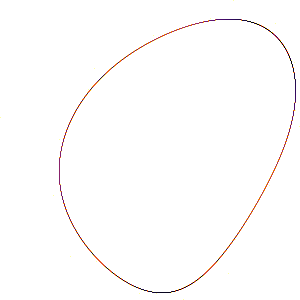
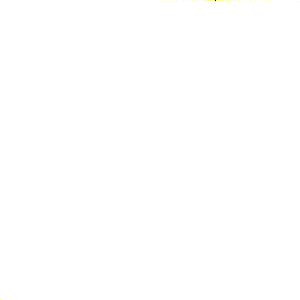
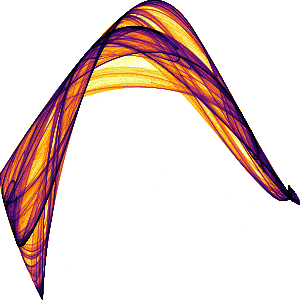
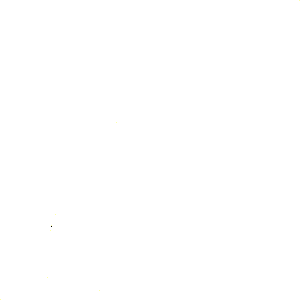
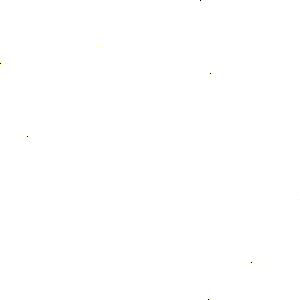
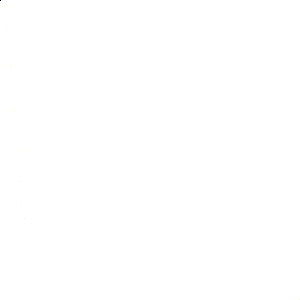
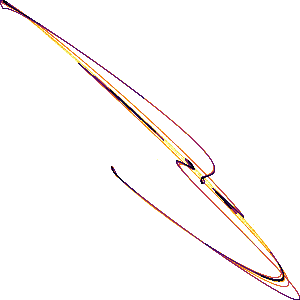
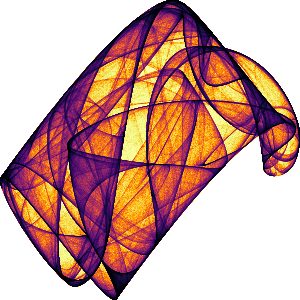
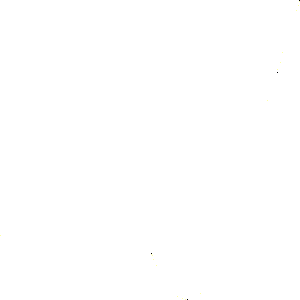
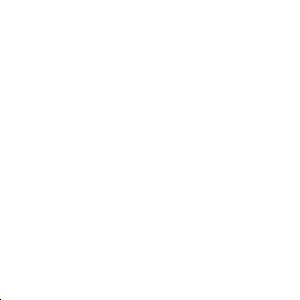
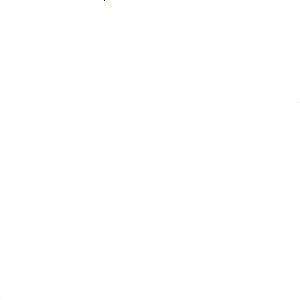
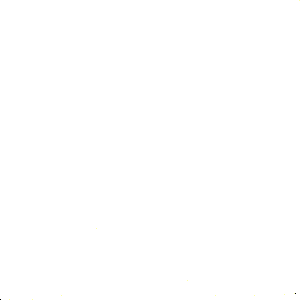
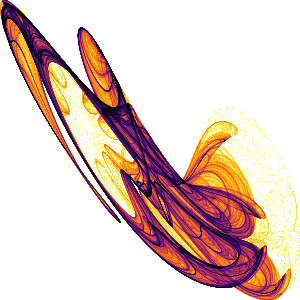
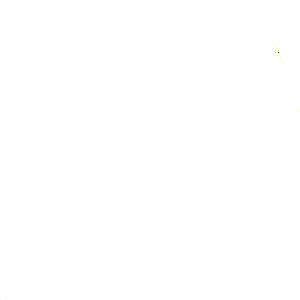
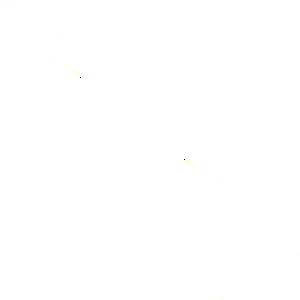
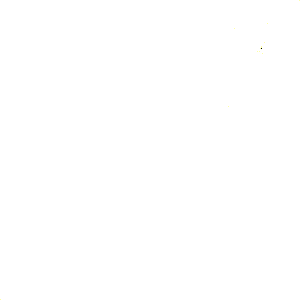

In [87]:
import numpy.random
numpy.random.seed(27753)
num = 16

rvals=np.c_[np.zeros((num,2)), numpy.random.random((num,4))*4-2]
plot(Chor2, vals=[["inferno"]+list(rvals[i]) for i in range(len(rvals))], label=True)

In [ ]:
def hv_clif(a,b,c,d,x0=0,y0=0,n=n):
    return datashade(hv.Points(trajectory(Clifford, x0, y0, a, b, c, d, n)), 
                     cmap=inferno[::-1], dynamic=False)

x0,y0,a,b,c,d = args("Clifford")[6][1:]

dm = hv.DynamicMap(hv_clif, kdims=['a', 'b', 'c', 'd'])
dm = dm.redim.range(a=(-2.0, 2.0), b=(-2.0,2.0), c=(-2.0,2.0), d=(-2.0,2.0))
dm = dm.redim.default(a=a, b=b, c=c, d=d).opts(width=500,height=500)
dm